In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

import tensorflow
import numpy as np
from tensorflow import keras
import random
import pandas as pd


SEED = 42



os.environ['PYTHONHASHSEED'] = str(SEED)

os.environ['TF_DETERMINISTIC_OPS'] = '1'



tensorflow.random.set_seed(SEED)

np.random.seed(SEED)

random.seed(SEED)

from keras import layers
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras import backend as K
session_conf = tensorflow.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tensorflow.compat.v1.Session(graph=tensorflow.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)


In [3]:
!pip install /content/drive/MyDrive/HAI/eTaPR-21.8.2-py3-none-any.whl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./drive/MyDrive/HAI/eTaPR-21.8.2-py3-none-any.whl


In [4]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

from tqdm.notebook import trange
from TaPR_pkg import etapr
from pathlib import Path
import time


In [5]:
train_data1 = pd.read_csv("/content/drive/MyDrive/HAI/train1.csv", sep=";", engine="python")
train_data2 = pd.read_csv("/content/drive/MyDrive/HAI/train2.csv", sep=";", engine="python")

In [6]:
TRAIN_DF_RAW = pd.concat([train_data1, train_data2], axis=0).reset_index(drop=True)

In [7]:
TIMESTAMP_FIELD = "time"
ATTACK_FIELD = "attack"
USELESS_FIELDS = ["attack_P1", "attack_P2", "attack_P3",'P1_PCV02D', 'P2_Auto','P2_Emgy','P2_On','P2_TripEx','P3_LH','P3_LL','P4_HT_PS']
VALID_COLUMNS_IN_TRAIN_DATASET = TRAIN_DF_RAW.columns.drop(
    [TIMESTAMP_FIELD, ATTACK_FIELD] + USELESS_FIELDS
)
f1=['P1_B3004', 'P1_LIT01']
f2=['P1_B3005', 'P1_FCV03D', 'P1_FCV03Z', 'P1_FT01', 'P1_FT01Z', 'P1_FT03', 'P1_FT03Z', 'P1_LCV01D', 'P1_LCV01Z']

f3=['P1_B4002', 'P1_B4022', 'P1_TIT01', 'P4_ST_TT01']

f4=['P1_B3005', 'P1_FCV03D', 'P1_FCV03Z', 'P1_FT03', 'P1_FT03Z']

f5=['P1_B3005', 'P1_FT01', 'P1_FT01Z', 'P1_FT03', 'P1_FT03Z', 'P1_LCV01D', 'P1_LCV01Z']
f6=['P1_PCV02D', 'P1_PCV02Z']

f7=['P1_PIT01', 'P4_ST_PT01']

f8=['P1_TIT01', 'P1_TIT02']
f9=['P2_VXT02', 'P2_VXT03', 'P2_VYT02']
f10=['P2_VYT02', 'P2_VYT03', 'P2_VXT03']
f11=['P2_VYT02', 'P2_VYT03']
f12=['P1_PIT01', 'P4_ST_PT01']
f13=['P1_B4002', 'P1_B4022', 'P1_TIT01', 'P4_ST_TT01']
f14=['P1_TIT01', 'P4_ST_TT01']

In [8]:
VALID_COLUMNS_IN_TRAIN_DATASET=f11

In [9]:
TAG_MIN = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].min()
TAG_MAX = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].max()

In [10]:
def normalize(df):
    ndf = df.copy()
    for c in df.columns:
        if TAG_MIN[c] == TAG_MAX[c]:
            ndf[c] = df[c] - TAG_MIN[c]
        else:
            ndf[c] = (df[c] - TAG_MIN[c]) / (TAG_MAX[c] - TAG_MIN[c])
    return ndf

In [11]:
TRAIN_DF = normalize(TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET])

In [12]:
def boundary_check(df):
    x = np.array(df, dtype=np.float32)
    return np.any(x > 1.0), np.any(x < 0), np.any(np.isnan(x))

In [13]:
boundary_check(TRAIN_DF)

(False, False, False)

In [14]:
def temporalize(X, y, timesteps):
    output_X = []
    output_y = []
    for i in range(len(X) - timesteps - 1):
        t = []
        for j in range(1, timesteps + 1):
            t.append(X[[(i + j + 1)], :])
        output_X.append(t)
        output_y.append(y[i + timesteps + 1])
    return np.squeeze(np.array(output_X)), np.array(output_y)

In [15]:
train = np.array(TRAIN_DF)
x_train = train.reshape(train.shape[0], 1, train.shape[1])
x_train.shape

(550800, 1, 2)

In [16]:
def conv_auto_model(x):
    n_steps = x.shape[1]
    n_features = x.shape[2]

    keras.backend.clear_session()

    model = keras.Sequential(
        [
            layers.Input(shape=(n_steps, n_features)),
            layers.Conv1D(filters=128, kernel_size=48, padding='same', data_format='channels_last',
                          dilation_rate=1, activation="linear"),
            layers.BatchNormalization(),
            layers.Dense(128),
            layers.Bidirectional(layers.LSTM(
                units=64, activation="relu", name="lstm_1", return_sequences=False
            )),
            layers.Dense(64),
            layers.RepeatVector(n_steps),
            layers.Dense(64),
            layers.Bidirectional(layers.LSTM(
                units=64, activation="relu", name="lstm_2", return_sequences=True
            )),
            layers.Dense(128),
            layers.Conv1D(filters=128, kernel_size=48, padding='same', data_format='channels_last',
                          dilation_rate=1, activation="linear"),
            layers.TimeDistributed(layers.Dense(x.shape[2], activation='linear'))
        ]
    )
    return model

In [17]:
model = conv_auto_model(x_train)
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1, 128)            12416     
                                                                 
 batch_normalization (BatchN  (None, 1, 128)           512       
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 1, 128)            16512     
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 repeat_vector (RepeatVector  (None, 1, 64)            0

In [18]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

epochs = 50
batch = 128

# fit
history = model.fit(x_train, x_train,
                     epochs=epochs, batch_size=batch,
                     validation_split=0.2, callbacks=[early_stopping]).history

model.save('F11model.h5')

Epoch 1/50
3443/3443 [==============================] - 84s 20ms/step - loss: 0.0014 - val_loss: 4.6175e-04
Epoch 2/50
3443/3443 [==============================] - 66s 19ms/step - loss: 6.8537e-04 - val_loss: 1.9065e-04
Epoch 3/50
3443/3443 [==============================] - 67s 19ms/step - loss: 6.5186e-04 - val_loss: 2.0597e-04
Epoch 4/50
3443/3443 [==============================] - 67s 19ms/step - loss: 6.2687e-04 - val_loss: 1.1914e-04
Epoch 5/50
3443/3443 [==============================] - 68s 20ms/step - loss: 5.9698e-04 - val_loss: 1.8004e-04
Epoch 6/50
3443/3443 [==============================] - 67s 19ms/step - loss: 5.8342e-04 - val_loss: 4.0858e-04
Epoch 7/50
3443/3443 [==============================] - 67s 19ms/step - loss: 5.5175e-04 - val_loss: 1.1668e-04
Epoch 8/50
3443/3443 [==============================] - 66s 19ms/step - loss: 5.2610e-04 - val_loss: 0.0014
Epoch 9/50
3443/3443 [==============================] - 66s 19ms/step - loss: 5.5286e-04 - val_loss: 1.2971e-04


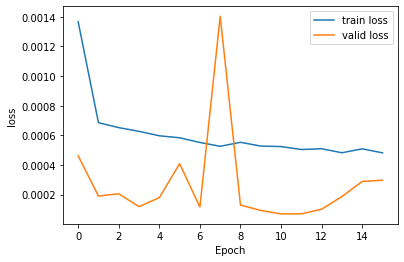

In [19]:
plt.plot(history['loss'], label='train loss')
plt.plot(history['val_loss'], label='valid loss')
plt.legend()
plt.xlabel('Epoch'); plt.ylabel('loss')
plt.show()

In [20]:
model = load_model('F11model.h5')

In [21]:
test_data1 = pd.read_csv("/content/drive/MyDrive/HAI/test1.csv", sep=";", engine="python")
test_data2 = pd.read_csv("/content/drive/MyDrive/HAI/test2.csv", sep=";", engine="python")

In [22]:
TEST_DF_RAW = pd.concat([test_data1, test_data2], axis=0).reset_index(drop=True)

In [23]:
TEST_DF = normalize(TEST_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET])
TEST_DF

,P2_VYT02,P2_VYT03
0,0.207999,0.303717
1,0.533228,0.492716
2,0.689985,0.427806
3,0.432752,0.179306
4,0.139864,0.112629
...,...,...
444595,0.345249,0.388496
444596,0.624510,0.450835
444597,0.589836,0.272172
444598,0.272261,0.067106


In [24]:
boundary_check(TEST_DF)

(True, True, False)

In [25]:
TEST_DF

,P2_VYT02,P2_VYT03
0,0.207999,0.303717
1,0.533228,0.492716
2,0.689985,0.427806
3,0.432752,0.179306
4,0.139864,0.112629
...,...,...
444595,0.345249,0.388496
444596,0.624510,0.450835
444597,0.589836,0.272172
444598,0.272261,0.067106


In [26]:
def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

def scale(X, scaler):
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
        
    return X

In [27]:
test = np.array(TEST_DF)
x_test = test.reshape(test.shape[0], 1, test.shape[1])
x_test.shape

(444600, 1, 2)

In [28]:
start = time.time()
test_x_predictions = model.predict(x_test)
print(test_x_predictions.shape)

error = flatten(x_test) - flatten(test_x_predictions)
print((flatten(x_test) - flatten(test_x_predictions)).shape)

test_mse = np.mean(np.power(flatten(x_test) - flatten(test_x_predictions), 2), axis=1)
print(test_mse.shape)
print(time.time()-start)

13894/13894 [==============================] - 70s 5ms/step
(444600, 1, 2)
(444600, 2)
(444600,)
84.38510131835938


In [29]:
test_error = pd.DataFrame({'Reconstruction_error': test_mse})

In [30]:
move = 80
test_move = test_error['Reconstruction_error'].rolling(move, center=True).mean()

test_d = test_move.fillna(0)
test_d

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
444595    0.0
444596    0.0
444597    0.0
444598    0.0
444599    0.0
Name: Reconstruction_error, Length: 444600, dtype: float64

In [31]:
movemean_test = pd.DataFrame({'Reconstruction_error': test_d})

In [32]:
pred_y = [1 if e > 0.0018 else 0 for e in movemean_test['Reconstruction_error'].values]
pred_y = np.array(pred_y)
pred_y.shape

(444600,)

In [33]:
ATTACK_LABELS = np.array(TEST_DF_RAW[ATTACK_FIELD])
FINAL_LABELS = np.array(pred_y)

ATTACK_LABELS.shape[0] == FINAL_LABELS.shape[0]

True

In [34]:
TaPR = etapr.evaluate_haicon(anomalies=ATTACK_LABELS, predictions=FINAL_LABELS)
print(f"F1: {TaPR['f1']:.3f} (TaP: {TaPR['TaP']:.3f}, TaR: {TaPR['TaR']:.3f})")
print(f"# of detected anomalies: {len(TaPR['Detected_Anomalies'])}")
print(f"Detected anomalies: {TaPR['Detected_Anomalies']}")

F1: 0.394 (TaP: 0.951, TaR: 0.248)
# of detected anomalies: 10
Detected anomalies: [<TaPR_pkg.DataManage.Range.Range object at 0x7f398c846ca0>, <TaPR_pkg.DataManage.Range.Range object at 0x7f398c846dc0>, <TaPR_pkg.DataManage.Range.Range object at 0x7f398c846e50>, <TaPR_pkg.DataManage.Range.Range object at 0x7f398c846e80>, <TaPR_pkg.DataManage.Range.Range object at 0x7f398c846ee0>, <TaPR_pkg.DataManage.Range.Range object at 0x7f398c846f40>, <TaPR_pkg.DataManage.Range.Range object at 0x7f398c846fa0>, <TaPR_pkg.DataManage.Range.Range object at 0x7f398c8355b0>, <TaPR_pkg.DataManage.Range.Range object at 0x7f398c835610>, <TaPR_pkg.DataManage.Range.Range object at 0x7f398c835640>]


In [35]:
submission = pd.read_csv('/content/drive/MyDrive/HAI/sample_submission.csv')
submission.index = submission['timestamp']
submission['attack'] = pred_y

In [36]:
submission['attack'].value_counts()

0    438569
1      6031
Name: attack, dtype: int64

In [ ]:
submission.to_csv('f11-find6031.csv', index=False)